In [1]:
from keras import backend as K 
K.clear_session()
import pandas as pd
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from tensorflow.keras.layers import SpatialDropout2D, Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D, BatchNormalization, MaxPooling2D, Input, Concatenate, ReLU, AveragePooling2D, UpSampling2D
# from tensorflow.keras.applications import DenseNet201, InceptionResNetV2, MobileNetV2, EfficientNetB3, Xception, VGG19, InceptionV3, EfficientNetB0, EfficientNetB2, Xception
from tensorflow.keras import regularizers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import random
import shutil
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC,Precision,Recall
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.callbacks import Callback

target = 224


In [2]:
dataPath='final/'

In [3]:
# combine two unique generators using noise injection
batchSize = 4

trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, vertical_flip=True, rotation_range=0, brightness_range=(0.95, 1.05))

# trainDataGen = ImageDataGenerator(preprocessing_function=apply_clahe, horizontal_flip=True, vertical_flip=True, rotation_range=0, brightness_range=(0.95, 1.05))
# trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_image, horizontal_flip=True, vertical_flip=True, rotation_range=0, brightness_range=(0.95, 1.05))

trainGen1 = trainDataGen.flow_from_directory(batch_size=batchSize, shuffle=True, class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=0)

trainGen2 = trainDataGen.flow_from_directory(batch_size=batchSize, shuffle=True, class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=42)

def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

trainGen = combine_gen(trainGen1, trainGen2)

valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
valGen = valDataGen.flow_from_directory(batch_size=1, class_mode="binary", target_size=(target, target), directory=dataPath + 'validation', color_mode='rgb')

testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
testGen = testDataGen.flow_from_directory(batch_size=1, class_mode="binary", target_size=(target, target), directory=dataPath + 'test', color_mode='rgb')

Found 629 images belonging to 2 classes.
Found 629 images belonging to 2 classes.
Found 41 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [4]:
from keras.layers.pooling.global_max_pooling2d import GlobalMaxPool2D
from tensorflow.nn import relu6
from tensorflow.keras.activations import elu
# simple model that uses mobilenet background
def getModel(image_size, num_classes=1):
    model_input = Input(shape=(image_size, image_size, 3))
    
    transfer =ResNet50(
        weights='imagenet', include_top=False, input_tensor=model_input,classifier_activation='elu'
    )
    x = transfer.get_layer(index=142).output
    
    x = SpatialDropout2D(0.15)(x)
    x = Conv2D(filters=64, kernel_size=1, activation='swish', kernel_regularizer=regularizers.L1L2(l1=1e-1))(x)
    x = GlobalMaxPool2D()(x)
    x = Dropout(0.20)(x)

    model_output = Dense(1, activation='sigmoid') (x)

    return Model(inputs=model_input, outputs=model_output)

model = getModel(image_size=target, num_classes=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=2, min_lr=1e-5) # factor=0.85
model_checkpoint_callback = ModelCheckpoint(
    filepath='anemia_model-resnet50.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=5,             # Number of epochs without improvement before stopping
    mode='min',             # 'min' since we want to stop when loss stops decreasing
    restore_best_weights=True  # Restore the model with the best weights 
)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

In [6]:
from tensorflow.keras.metrics import BinaryAccuracy,Precision,Recall,AUC
import keras

In [7]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy', keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(trainGen, steps_per_epoch=len(trainGen1)*2, validation_data=valGen, validation_steps=len(valGen), epochs=20, callbacks=[reduce_lr, model_checkpoint_callback, early_stopping])

Epoch 1/20
316/316 [==============================] - 37s 80ms/step - loss: 166.7724 - binary_accuracy: 0.5747 - auc: 0.5655 - precision: 0.4790 - recall: 0.4669 - val_loss: 98.7863 - val_binary_accuracy: 0.4634 - val_auc: 0.6217 - val_precision: 0.3462 - val_recall: 0.6429 - lr: 1.0000e-04
Epoch 2/20
316/316 [==============================] - 23s 73ms/step - loss: 54.1472 - binary_accuracy: 0.6479 - auc: 0.6718 - precision: 0.5757 - recall: 0.5253 - val_loss: 20.0814 - val_binary_accuracy: 0.6585 - val_auc: 0.6376 - val_precision: 0.5000 - val_recall: 0.2857 - lr: 1.0000e-04
Epoch 3/20
316/316 [==============================] - 23s 73ms/step - loss: 8.0503 - binary_accuracy: 0.6860 - auc: 0.7418 - precision: 0.6337 - recall: 0.5486 - val_loss: 2.5718 - val_binary_accuracy: 0.6829 - val_auc: 0.7950 - val_precision: 0.5238 - val_recall: 0.7857 - lr: 1.0000e-04
Epoch 4/20
316/316 [==============================] - 23s 73ms/step - loss: 1.4970 - binary_accuracy: 0.7210 - auc: 0.7860 - pre

In [8]:
model.load_weights('anemia_model-resnet50.h5')

In [9]:
model.evaluate(testGen)

40/40 [==============================] - 1s 15ms/step - loss: 0.4307 - binary_accuracy: 0.9250 - auc: 0.9653 - precision: 0.8750 - recall: 0.9333


[0.4307454228401184,
 0.925000011920929,
 0.9653334021568298,
 0.875,
 0.9333333373069763]

40/40 [==============================] - 1s 12ms/step


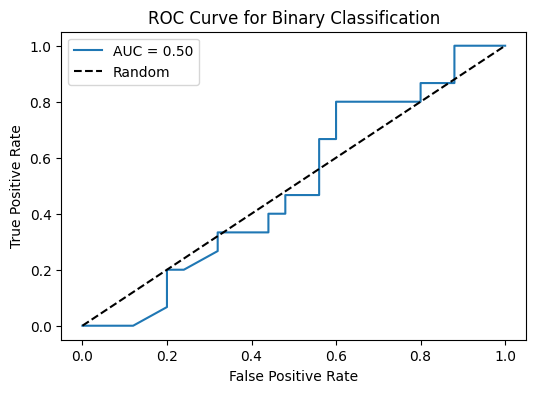

In [10]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities on the test set
y_score = model.predict(testGen, steps=len(testGen), verbose=1)

# Get true labels
y_true = testGen.classes

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve using seaborn
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification')
plt.legend()
plt.show()

40/40 [==============================] - 1s 13ms/step


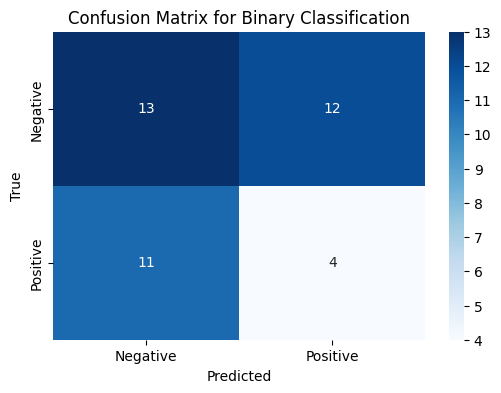

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict probabilities on the test set
y_pred_prob = model.predict(testGen, steps=len(testGen), verbose=1)

# Get predicted class labels
y_pred = np.round(y_pred_prob)  # Round probabilities to 0 or 1

# Create confusion matrix for binary classification
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Binary Classification')
plt.show()

NameError: name 'test_accuracy' is not defined

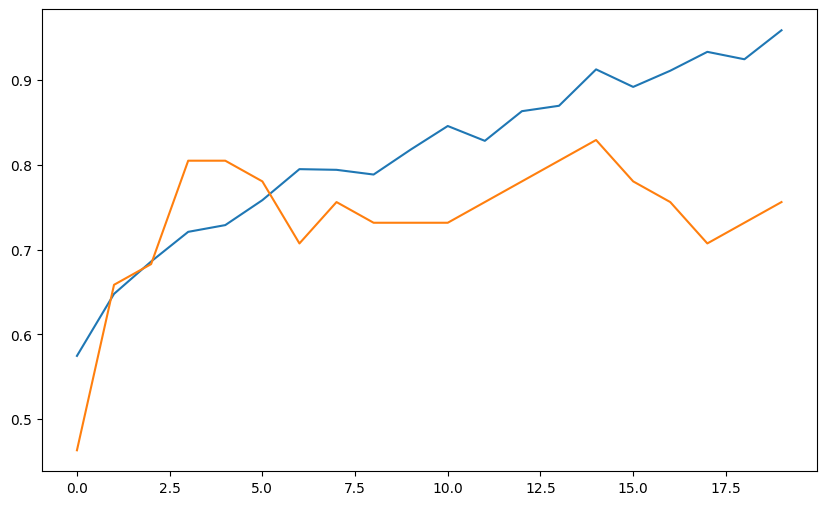

In [12]:
# Plot the training, validation, and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy = {test_accuracy:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

In [13]:
from sklearn.metrics import f1_score

# Get the true labels and predicted labels
y_true = testGen.classes
y_pred = np.round(model.predict(testGen, steps=len(testGen), verbose=1))

# Calculate the F1-score
f1 = f1_score(y_true, y_pred)
print(f"F1-score: {f1:.4f}")

40/40 [==============================] - 1s 17ms/step
F1-score: 0.3871


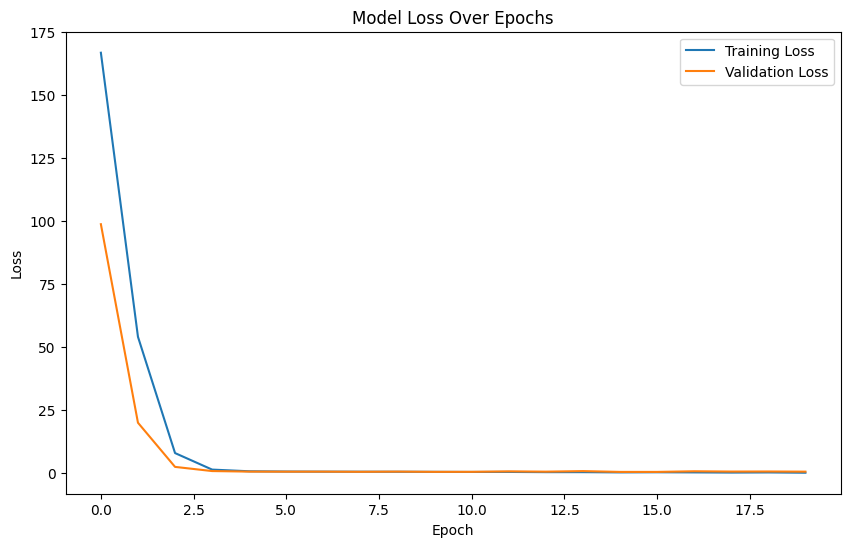

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
mode